# Nombre: Ulises Gallardo Rodríguez

# Tarea 3 Segundo Parcial / Modelos de Lenguaje Estadísticos

In [471]:
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
from sklearn.model_selection import train_test_split
from IPython import display

## 2.1 Preprocess dataset

In [363]:
def get_tweets_from_file(path_corpus):
    tr_tweet = []    
    with open(path_corpus, "r") as f_corpus:
        for tweet in f_corpus:
            tr_tweet += [tweet]
    return tr_tweet

In [364]:
def define_vocabulary(corpus, size):
    corpus_words = []
    for doc in corpus:
        corpus_words += tokenizer.tokenize(doc)
    fdist = nltk.FreqDist(corpus_words)
    V = [(fdist[key], key) for key in fdist]
    V.sort() 
    V.reverse()
    V = V[:size]
    V = [word for count, word in V]
    return V

In [453]:
def preprocess_corpus(corpus, volcabulary_size):
    # Make sure all tweets are in lowercase.
    for i in range(len(corpus)):
        corpus[i]= corpus[i].lower()
    # Define vocabulary with the 500 most frequent words.
    V = define_vocabulary(corpus, volcabulary_size)
    # Rebuild corpus
    new_corpus = []
    for tweet in corpus:
        words = tokenizer.tokenize(tweet)    
        new_words = ["<unk>" if word not in V else word for word in words] # New lexicon with unknown words
        new_corpus.append(new_words)
    return new_corpus, V

In [454]:
tr_tweet = get_tweets_from_file("./mex_train.txt")

In [455]:
tr_tweet, V = preprocess_corpus(tr_tweet, 500)

## 2.2 N-grams training

In [417]:
def n_grams_counts(tr_txt, n):
    Count = {}
    for i in range(len(tr_txt)):
        tweet = tr_txt[i]
        start = []
        end = [" </s>"]
        for i in range(max(1,n-1)):
            start.append("<s>")
        words = start+tweet+end 
        for index, word in enumerate(words[n-1:]):
            context = word
            for j in range(1,n):
                context = words[(index + n -1) - j] + " " + context
            if Count.get(context) is not None:
                Count[context] += 1
            else:
                Count[context] = 1
    return Count

In [437]:
def get_probabilities(Count_n_prev_gram, Count_n_gram, n, tr_txt_size, V):
    is_unigram = np.isscalar(Count_n_prev_gram)
    Probablilities = {}

    start = ""
    for i in range(max(1,n-1)):
        start += "<s>"
        if i<n-2:
            start+=" "
            
    if is_unigram:
        for word, count in Count_n_gram.items():
            Probablilities[word] = count/Count_n_prev_gram
    else:
        for word, count in Count_n_gram.items():
            s = word
            last = word.split(" ").pop()
            s = s[:-(len(last)+1)].rstrip()
            count_prev = 0
            
            try :
                if s == start:
                    count_prev = tr_txt_size
                else:
                    count_prev = Count_n_prev_gram[s]
                Probablilities[word] = (count + 1) / (count_prev + len(V)) # Laplace Smoothing 
            except:
                print(s)
    return Probablilities

### test with a small example

In [456]:
tr_prueba = get_tweets_from_file("./prueba.txt")
corpus_prueba, V_prueba = preprocess_corpus(tr_prueba, 5)

In [457]:
corpus_prueba

[['i', 'am', 'sam'],
 ['sam', 'i', 'am'],
 ['i', '<unk>', 'not', 'like', '<unk>', '<unk>', '<unk>', '<unk>']]

In [458]:
V_prueba

['i', 'sam', 'am', 'not', 'like']

In [459]:
Count_unigram = n_grams_counts(corpus_prueba, 1)
Count_bigram = n_grams_counts(corpus_prueba, 2)
Count_trigram = n_grams_counts(corpus_prueba, 3)

In [460]:
Count_unigram

{'<s>': 3,
 'i': 3,
 'am': 2,
 'sam': 2,
 ' </s>': 3,
 '<unk>': 5,
 'not': 1,
 'like': 1}

In [461]:
Count_bigram

{'<s> i': 2,
 'i am': 2,
 'am sam': 1,
 'sam  </s>': 1,
 '<s> sam': 1,
 'sam i': 1,
 'am  </s>': 1,
 'i <unk>': 1,
 '<unk> not': 1,
 'not like': 1,
 'like <unk>': 1,
 '<unk> <unk>': 3,
 '<unk>  </s>': 1}

In [462]:
get_probabilities(Count_unigram, Count_bigram, 2, len(tr_prueba), V)

{'<s> i': 0.005964214711729622,
 'i am': 0.005964214711729622,
 'am sam': 0.00398406374501992,
 'sam  </s>': 0.00398406374501992,
 '<s> sam': 0.003976143141153081,
 'sam i': 0.00398406374501992,
 'am  </s>': 0.00398406374501992,
 'i <unk>': 0.003976143141153081,
 '<unk> not': 0.0039603960396039604,
 'not like': 0.003992015968063872,
 'like <unk>': 0.003992015968063872,
 '<unk> <unk>': 0.007920792079207921,
 '<unk>  </s>': 0.0039603960396039604}

In [463]:
get_probabilities(Count_bigram, Count_trigram,3, len(tr_prueba), V)

{'<s> <s> i': 0.005964214711729622,
 '<s> i am': 0.00398406374501992,
 'i am sam': 0.00398406374501992,
 'am sam  </s>': 0.003992015968063872,
 '<s> <s> sam': 0.003976143141153081,
 '<s> sam i': 0.003992015968063872,
 'sam i am': 0.003992015968063872,
 'i am  </s>': 0.00398406374501992,
 '<s> i <unk>': 0.00398406374501992,
 'i <unk> not': 0.003992015968063872,
 '<unk> not like': 0.003992015968063872,
 'not like <unk>': 0.003992015968063872,
 'like <unk> <unk>': 0.003992015968063872,
 '<unk> <unk> <unk>': 0.005964214711729622,
 '<unk> <unk>  </s>': 0.003976143141153081}

Explicar cómo funciona el Laplace smoothing, y hablar sobre sus ventajas y desventajas, así como alternativas. así como una imagen de los valores esperados.

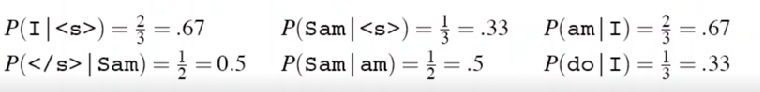

In [475]:
display.Image("example_bigram.PNG")

### Corpus training 

In [464]:
Count_unigram = n_grams_counts(tr_tweet, 1)
Count_bigram = n_grams_counts(tr_tweet, 2)
Count_trigram = n_grams_counts(tr_tweet, 3)

In [465]:
unigram =  get_probabilities(len(V), Count_bigram, 2, len(tr_tweet), V)
bigram = get_probabilities(Count_unigram, Count_bigram, 2, len(tr_tweet), V)
trigram = get_probabilities(Count_bigram, Count_trigram, 3 , len(tr_tweet), V)

## 2.3 Interpolated model

In [468]:
tr_tweet_train, tr_tweet_test = train_test_split(tr_tweet, test_size = 0.2)
tr_tweet_test, tr_tweet_val = train_test_split(tr_tweet_test, test_size = 0.5)

### perplexity

Perplexity is the inverse probability of the test set, normalized by the number of words. Minimizing perplexity is the same as maximizing probability

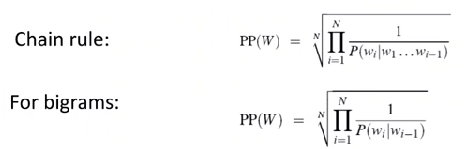

In [473]:
display.Image("perplejidad.PNG")

In [469]:
lambdas = [
    [1/3, 1/3, 1/3],
    [.4, .4, .2],
    [.2, .4, .4],
    [.5, .4, .1],
    [.1, .4, .5]
]

In [ ]:
def get_perfplexity():
    pass